Import needed libs:

In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal

Load .mat data and covert to proper python arrays:

In [6]:
matData = scipy.io.loadmat('Painless021.mat')

print(type(matData))
print(matData)

bp = matData.get('bp')[0] # not sure why you get arrays of arrays
ecg = matData.get('ecg')[0] # note: this is 3x array
ppg = matData.get('ppg')[0]

f_bp = matData.get('f_bp')[0]
f_ecg = matData.get('f_ecg')[0]
f_ppg = matData.get('f_ppg')[0]

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Nov  3 22:29:57 2022', '__version__': '1.0', '__globals__': [], 'bp': array([[72.81, 72.11, 71.56, ..., 70.3 , 71.16, 72.64]]), 'ecg': array([[-0.00082984, -0.00081711, -0.00081434, ..., -0.00232391,
        -0.00233045, -0.00232606],
       [-0.00209742, -0.00207858, -0.00207047, ...,  0.00073009,
         0.00072508,  0.00072484],
       [-0.00160103, -0.00159402, -0.00158911, ...,  0.00271969,
         0.0027215 ,  0.00271502]]), 'f_bp': array([[100]], dtype=uint8), 'f_ecg': array([[2000]], dtype=uint16), 'f_ppg': array([[1000]], dtype=uint16), 'ppg': array([[2087000, 2087268, 2087604, ..., 2396945, 2396970, 2396976],
       [1694830, 1695004, 1695136, ..., 1893987, 1893996, 1894017]])}


Plot initial data:


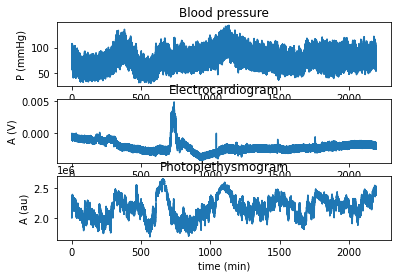

In [11]:
plt.figure()
plt.subplot(311)
time_bp = range(0, len(bp)) /f_bp
plt.plot(time_bp, bp)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')

plt.subplot(312)
time_ecg = range(0, len(ecg)) /f_ecg
plt.plot(time_ecg, ecg)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')

plt.subplot(313)
time_ppg = range(0, len(ppg)) /f_ppg
plt.plot(time_ppg, ppg)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.show()